In [6]:
import requests
import time
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv
load_dotenv()

True

In [7]:
# Kraken API endpoint
url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=MSFT&outputsize=full&apikey={alphavantage_api_key}".format(alphavantage_api_key=os.getenv("ALPHAVANTAGE_API_KEY"))


In [8]:

# Make the API request
response = requests.get(url)
data = response.json()
print(data)  # Print the raw data for debugging

short_term_window = 5  # Short-term moving average window
long_term_window = 20  # Long-term moving average window


{'Meta Data': {'1. Information': 'Daily Prices (open, high, low, close) and Volumes', '2. Symbol': 'MSFT', '3. Last Refreshed': '2025-03-14', '4. Output Size': 'Full size', '5. Time Zone': 'US/Eastern'}, 'Time Series (Daily)': {'2025-03-14': {'1. open': '379.7750', '2. high': '390.2300', '3. low': '379.5100', '4. close': '388.5600', '5. volume': '19952846'}, '2025-03-13': {'1. open': '383.1550', '2. high': '385.3200', '3. low': '377.4500', '4. close': '378.7700', '5. volume': '20473017'}, '2025-03-12': {'1. open': '382.9500', '2. high': '385.2165', '3. low': '378.9507', '4. close': '383.2700', '5. volume': '24253567'}, '2025-03-11': {'1. open': '379.0000', '2. high': '386.0000', '3. low': '376.9100', '4. close': '380.4500', '5. volume': '30380177'}, '2025-03-10': {'1. open': '385.8400', '2. high': '386.4000', '3. low': '377.2200', '4. close': '380.1600', '5. volume': '32569768'}, '2025-03-07': {'1. open': '392.3200', '2. high': '394.8000', '3. low': '385.5400', '4. close': '393.3100', 

In [9]:
def CreateDF(data):
    # Convert the JSON data to a DataFrame
    df = pd.DataFrame.from_dict(data['Time Series (Daily)'], orient='index')
    # Rename the columns to remove the prefix
    df.columns = [col.split(' ')[1] for col in df.columns]
    # Rename the index to 'Date'
    df.index.name = 'Date'
    df.index = pd.to_datetime(df.index)
    df = df.apply(pd.to_numeric, errors='coerce')
    df.sort_index(inplace=True)
    return df



dateframe = CreateDF(data)
print(dateframe)

               open      high       low   close    volume
Date                                                     
1999-11-01   93.250   94.1900   92.1200   92.37  26630600
1999-11-02   92.750   94.5000   91.9400   92.56  23174500
1999-11-03   92.940   93.5000   91.5000   92.00  22258500
1999-11-04   92.310   92.7500   90.3100   91.75  27119700
1999-11-05   91.810   92.8700   90.5000   91.56  35083700
...             ...       ...       ...     ...       ...
2025-03-10  385.840  386.4000  377.2200  380.16  32569768
2025-03-11  379.000  386.0000  376.9100  380.45  30380177
2025-03-12  382.950  385.2165  378.9507  383.27  24253567
2025-03-13  383.155  385.3200  377.4500  378.77  20473017
2025-03-14  379.775  390.2300  379.5100  388.56  19952846

[6381 rows x 5 columns]


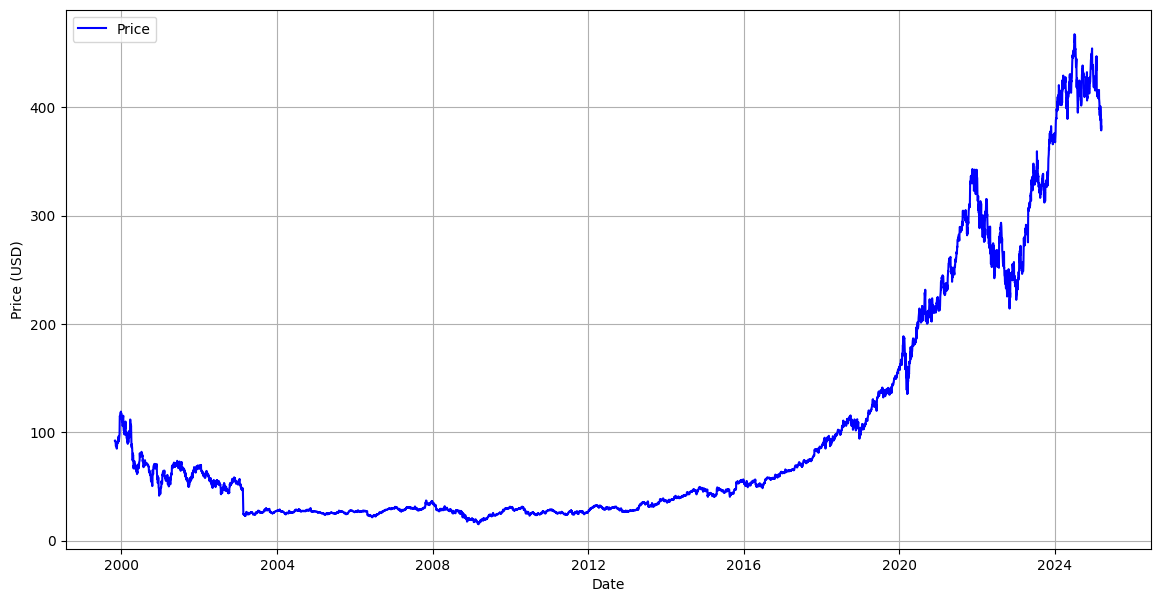

In [10]:
def graph_data(df):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['close'], label='Price', color='blue')    
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

graph_data(dateframe)

In [11]:
def calculate_sma(df, window): 
    return df['close'].rolling(window=window).mean()

short_momentum = calculate_sma(dateframe, short_term_window)
long_momentum = calculate_sma(dateframe, long_term_window)

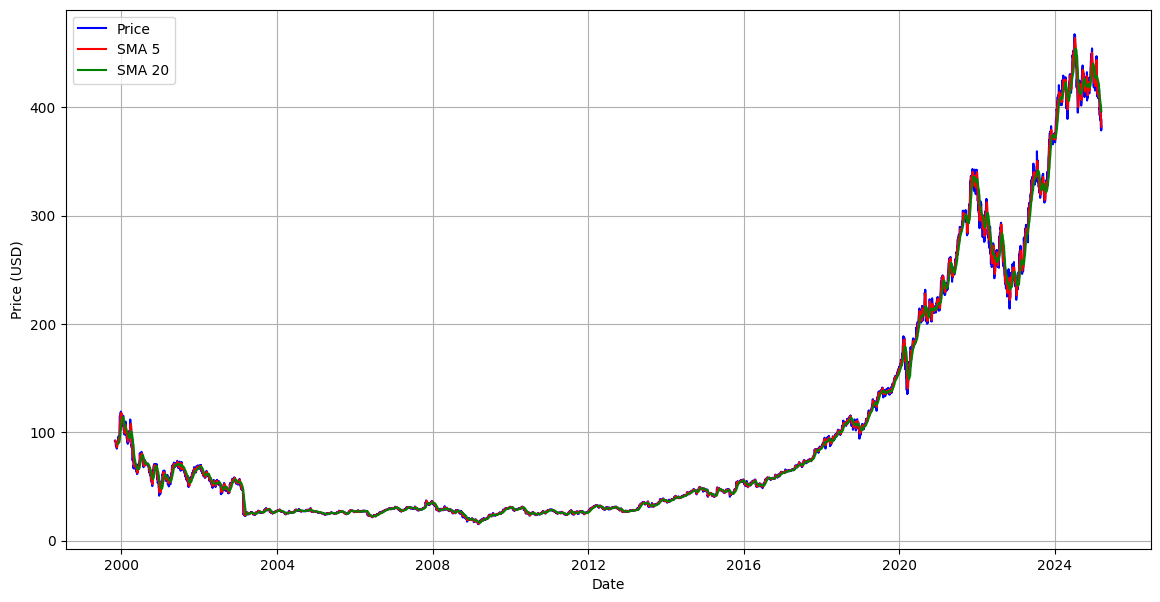

In [12]:
def plot_sma(df, short_momentum, long_momentum):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['close'], label='Price', color='blue')
    plt.plot(df.index, short_momentum, label=f'SMA {short_term_window}', color='red')
    plt.plot(df.index, long_momentum, label=f'SMA {long_term_window}', color='green')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

plot_sma(dateframe, short_momentum, long_momentum)

In [13]:
# Starting balance in USD
initial_balance = 100
btc_balance = 0
position = False
buy_price = 0
trade_log = []


def simulate_trading(df, short_momentum, long_momentum):
    global initial_balance, btc_balance, position, buy_price

    for i in range(1, len(df)):
        # Check for BUY signal
        if short_momentum.iloc[i] > long_momentum.iloc[i] and short_momentum.iloc[i - 1] <= long_momentum.iloc[i - 1]:
            if not position:
                # BUY action
                buy_price = df['close'].iloc[i]
                btc_balance = initial_balance / buy_price
                initial_balance = 0
                position = True
                trade_log.append({
                    'Date': df.index[i],
                    'Action': 'BUY',
                    'Price': buy_price,
                    'BTC Balance': btc_balance,
                    'USD Balance': initial_balance
                })
                print(f"BUY at {buy_price:.2f} on {df.index[i].date()}")

        # Check for SELL signal
        elif short_momentum.iloc[i] < long_momentum.iloc[i] and short_momentum.iloc[i - 1] >= long_momentum.iloc[i - 1]:
            if position:
                # SELL action
                sell_price = df['close'].iloc[i]
                initial_balance = btc_balance * sell_price
                btc_balance = 0
                position = False
                trade_log.append({
                    'Date': df.index[i],
                    'Action': 'SELL',
                    'Price': sell_price,
                    'BTC Balance': btc_balance,
                    'USD Balance': initial_balance
                })
                print(f"SELL at {sell_price:.2f} on {df.index[i].date()}")

    # Final value if holding BTC
    if position:
        final_price = df['close'].iloc[-1]
        initial_balance = btc_balance * final_price
        trade_log.append({
            'Date': df.index[-1],
            'Action': 'FINAL SELL',
            'Price': final_price,
            'BTC Balance': 0,
            'USD Balance': initial_balance
        })
        print(f"FINAL SELL at {final_price:.2f} on {df.index[-1].date()}")

simulate_trading(dateframe, short_momentum, long_momentum)

BUY at 109.94 on 2000-02-08
SELL at 98.56 on 2000-02-15
BUY at 101.00 on 2000-03-10
SELL at 88.56 on 2000-04-04
BUY at 69.62 on 2000-06-06
SELL at 73.12 on 2000-07-19
BUY at 72.44 on 2000-08-11
SELL at 71.12 on 2000-08-24
BUY at 62.13 on 2000-10-23
SELL at 68.25 on 2000-11-22
BUY at 51.81 on 2001-01-09
SELL at 58.19 on 2001-02-13
BUY at 60.69 on 2001-03-07
SELL at 51.94 on 2001-03-12
BUY at 55.56 on 2001-03-28
SELL at 53.38 on 2001-04-03
BUY at 56.19 on 2001-04-06
SELL at 69.16 on 2001-05-16
BUY at 71.72 on 2001-05-24
SELL at 68.02 on 2001-06-15
BUY at 73.00 on 2001-06-29
SELL at 66.06 on 2001-07-06
BUY at 71.82 on 2001-07-17
SELL at 66.32 on 2001-07-24
BUY at 56.44 on 2001-10-04
SELL at 62.80 on 2001-11-28
BUY at 68.10 on 2001-12-05
SELL at 66.25 on 2001-12-31
BUY at 68.90 on 2002-01-04
SELL at 64.46 on 2002-01-22
BUY at 63.08 on 2002-03-05
SELL at 60.45 on 2002-03-22
BUY at 54.75 on 2002-05-15
SELL at 50.91 on 2002-05-31
BUY at 55.54 on 2002-06-12
SELL at 51.44 on 2002-07-02
BUY at 4

In [14]:
trade_log_df = pd.DataFrame(trade_log)
print(trade_log_df)

          Date Action   Price  BTC Balance  USD Balance
0   2000-02-08    BUY  109.94     0.909587     0.000000
1   2000-02-15   SELL   98.56     0.000000    89.648899
2   2000-03-10    BUY  101.00     0.887613     0.000000
3   2000-04-04   SELL   88.56     0.000000    78.606995
4   2000-06-06    BUY   69.62     1.129086     0.000000
..         ...    ...     ...          ...          ...
399 2024-11-18   SELL  415.76     0.000000   145.875007
400 2024-11-27    BUY  422.99     0.344866     0.000000
401 2024-12-24   SELL  439.33     0.000000   151.510123
402 2025-01-22    BUY  446.20     0.339557     0.000000
403 2025-02-03   SELL  410.92     0.000000   139.530568

[404 rows x 5 columns]


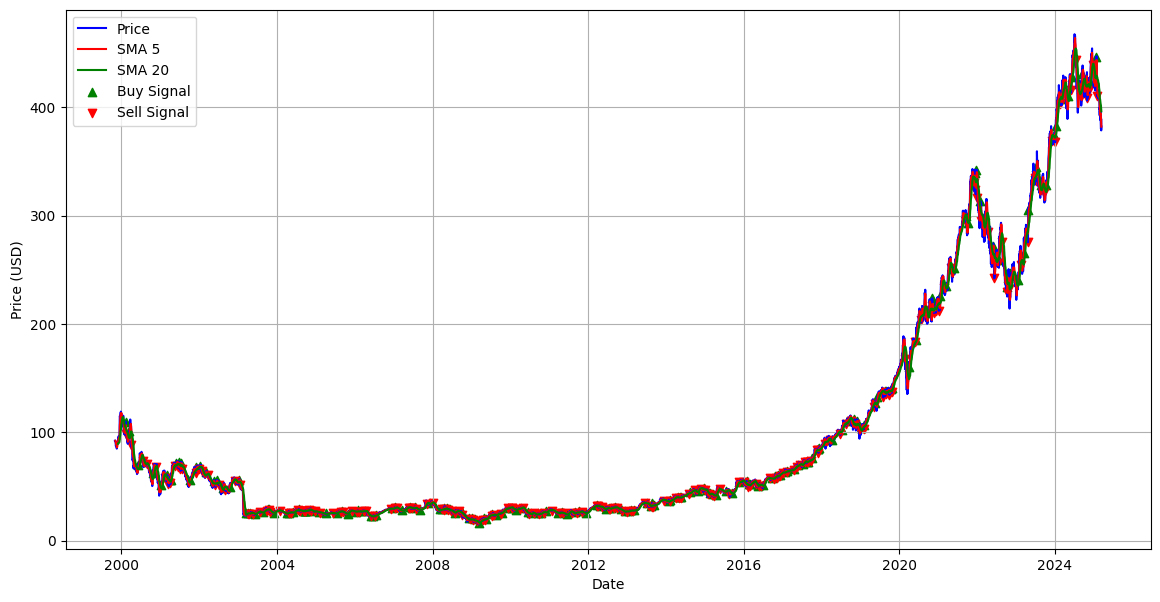

In [15]:
def plot_trades(df, short_momentum, long_momentum, trades):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['close'], label='Price', color='blue')
    plt.plot(df.index, short_momentum, label=f'SMA {short_term_window}', color='red')
    plt.plot(df.index, long_momentum, label=f'SMA {long_term_window}', color='green')

    # Plot Buy signals
    buys = trades[trades['Action'] == 'BUY']
    plt.scatter(buys['Date'], buys['Price'], marker='^', color='green', label='Buy Signal', alpha=1)

    # Plot Sell signals
    sells = trades[trades['Action'] == 'SELL']
    plt.scatter(sells['Date'], sells['Price'], marker='v', color='red', label='Sell Signal', alpha=1)

    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid()
    plt.show()

# Plot trades
plot_trades(dateframe, short_momentum, long_momentum, trade_log_df)

In [16]:
initial_value = 100
final_value = initial_balance
profit = final_value - initial_value
roi = (profit / initial_value) * 100

print(f"Initial Balance: ${initial_value:.2f}")
print(f"Final Balance: ${final_value:.2f}")
print(f"Profit: ${profit:.2f}")
print(f"ROI: {roi:.2f}%")

Initial Balance: $100.00
Final Balance: $139.53
Profit: $39.53
ROI: 39.53%
